# Инженерия признаков для многомерных временных рядов

Этот ноутбук предназначен для обогащения данных с интегрированными новостями дополнительными фичами:

## Этапы обработки:
1. **Технические индикаторы** - добавление технических индикаторов с помощью библиотеки `ta`
2. **Паттерны графиков** - обнаружение графических паттернов (опционально)
3. **Свойства временных рядов** - извлечение признаков с помощью `tsfresh`
4. **Сжатие размерности** - применение PCA для сжатия пространства признаков
5. **Статистика и сохранение** - анализ результатов и сохранение в `data/multivariate_series/`


In [27]:
import sys
print(sys.executable)

/workspace/news_processors/venvs/news/bin/python


In [28]:
import subprocess
import os
import sys

# Путь к pip в активном ядре
pip_path = os.path.join(sys.prefix, "bin", "pip")

subprocess.check_call([pip_path, "install", "matplotlib", "pandas", "numpy", "seaborn", "ta", "tsfresh"])

0

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Библиотеки для технических индикаторов
import ta

# Библиотеки для извлечения признаков временных рядов
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute

# Библиотеки для PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import os
from pathlib import Path

# Настройка отображения
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12

print("Библиотеки загружены успешно")

Библиотеки загружены успешно


In [30]:
# Пути к данным
INPUT_PATH = '../data/series_with_news/'
OUTPUT_PATH = '../data/multivariate_series/'

# Создаем выходную папку если её нет
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Список тикеров
tickers = ['AFLT', 'LKOH', 'MOEX', 'NVTK', 'PIKK', 'SBER', 'VKCO', 'VTBR', 'X5', 'YDEX']

print(f"Рабочие директории:")
print(f"- Входные данные (с новостями): {INPUT_PATH}")
print(f"- Выходные данные (многомерные): {OUTPUT_PATH}")
print(f"\nТикеры для обработки: {tickers}")

# Загружаем данные
df = {}
for ticker in tickers:
    try:
        file_path = f"{INPUT_PATH}{ticker}_with_news.csv"
        data = pd.read_csv(file_path)
        data['timestamp'] = pd.to_datetime(data['timestamp'])
        df[ticker] = data
        print(f"Загружен {ticker}: {data.shape}")
    except Exception as e:
        print(f"Ошибка загрузки {ticker}: {str(e)}")

print(f"\nУспешно загружено {len(df)} тикеров")

Рабочие директории:
- Входные данные (с новостями): ../data/series_with_news/
- Выходные данные (многомерные): ../data/multivariate_series/

Тикеры для обработки: ['AFLT', 'LKOH', 'MOEX', 'NVTK', 'PIKK', 'SBER', 'VKCO', 'VTBR', 'X5', 'YDEX']
Загружен AFLT: (2375, 16)
Загружен LKOH: (2375, 16)
Загружен MOEX: (2375, 16)
Загружен NVTK: (2373, 16)
Загружен PIKK: (2375, 16)
Загружен SBER: (2375, 16)
Загружен VKCO: (1197, 16)
Загружен VTBR: (1722, 16)
Загружен X5: (1499, 16)
Загружен YDEX: (2339, 16)

Успешно загружено 10 тикеров


## Этап 1: Добавление технических индикаторов


In [31]:
warnings.filterwarnings("ignore", category=FutureWarning, module='ta.trend')

df_ext = {}

for ticker, frame in df.items():
    print(f"Добавление технических индикаторов для {ticker}...")
    
    try:
        df0 = frame.copy().set_index('timestamp')

        # 1) Скользящие средние
        df0['SMA_14'] = df0['close'].rolling(14).mean()
        df0['SMA_50'] = df0['close'].rolling(50).mean()
        df0['EMA_14'] = ta.trend.EMAIndicator(df0['close'], window=14).ema_indicator()
        df0['EMA_50'] = ta.trend.EMAIndicator(df0['close'], window=50).ema_indicator()

        # 2) Momentum, ROC
        df0['Momentum_10'] = ta.momentum.ROCIndicator(df0['close'], window=10).roc()
        df0['Momentum_20'] = ta.momentum.ROCIndicator(df0['close'], window=20).roc()

        # 3) RSI, MFI
        df0['RSI_14'] = ta.momentum.RSIIndicator(df0['close'], window=14).rsi()
        df0['MFI_14'] = ta.volume.MFIIndicator(
            df0['high'], df0['low'], df0['close'], df0['volume'], window=14
        ).money_flow_index()

        # 4) Stochastic %K/%D, Williams %R
        stoch = ta.momentum.StochasticOscillator(
            df0['high'], df0['low'], df0['close'], window=14, smooth_window=3
        )
        df0['Stoch_%K'] = stoch.stoch()
        df0['Stoch_%D'] = stoch.stoch_signal()
        df0['Williams_%R'] = ta.momentum.WilliamsRIndicator(
            df0['high'], df0['low'], df0['close'], lbp=14
        ).williams_r()

        # 5) CCI, ADX/ADXR
        df0['CCI_20'] = ta.trend.CCIIndicator(
            df0['high'], df0['low'], df0['close'], window=20
        ).cci()
        adx = ta.trend.ADXIndicator(
            df0['high'], df0['low'], df0['close'], window=14
        )
        df0['ADX_14']  = adx.adx()
        df0['ADXR_14'] = df0['ADX_14'].rolling(window=14).mean()

        # 6) MACD
        macd = ta.trend.MACD(df0['close'])
        df0['MACD']        = macd.macd()
        df0['MACD_signal'] = macd.macd_signal()
        df0['MACD_diff']   = macd.macd_diff()

        # 7) Bollinger Bands
        bb = ta.volatility.BollingerBands(df0['close'], window=20, window_dev=2)
        df0['BB_hband'] = bb.bollinger_hband()
        df0['BB_lband'] = bb.bollinger_lband()
        df0['BB_mavg']  = bb.bollinger_mavg()

        # 8) ATR, Parabolic SAR
        df0['ATR_14'] = ta.volatility.AverageTrueRange(
            df0['high'], df0['low'], df0['close'], window=14
        ).average_true_range()
        df0['PSAR']   = ta.trend.PSARIndicator(
            df0['high'], df0['low'], df0['close'], step=0.02, max_step=0.2
        ).psar()

        # 9) Volume-based: OBV, CMF, VWAP
        df0['OBV'] = ta.volume.OnBalanceVolumeIndicator(
            df0['close'], df0['volume']
        ).on_balance_volume()
        df0['CMF_20'] = ta.volume.ChaikinMoneyFlowIndicator(
            df0['high'], df0['low'], df0['close'], df0['volume'], window=20
        ).chaikin_money_flow()
        
        # VWAP: (high+low+close)/3 * volume cumulative / volume cumulative
        tp = (df0['high'] + df0['low'] + df0['close']) / 3
        vwap = (tp * df0['volume']).cumsum() / df0['volume'].cumsum()
        df0['VWAP'] = vwap

        # сохраняем
        df_ext[ticker] = df0
        print(f"  - Успешно добавлены технические индикаторы. Размер: {df0.shape}")
        
    except Exception as e:
        print(f"  - Ошибка при добавлении технических индикаторов для {ticker}: {str(e)}")

print(f"\nТехнические индикаторы добавлены для {len(df_ext)} тикеров")

Добавление технических индикаторов для AFLT...
  - Успешно добавлены технические индикаторы. Размер: (2375, 40)
Добавление технических индикаторов для LKOH...
  - Успешно добавлены технические индикаторы. Размер: (2375, 40)
Добавление технических индикаторов для MOEX...
  - Успешно добавлены технические индикаторы. Размер: (2375, 40)
Добавление технических индикаторов для NVTK...
  - Успешно добавлены технические индикаторы. Размер: (2373, 40)
Добавление технических индикаторов для PIKK...
  - Успешно добавлены технические индикаторы. Размер: (2375, 40)
Добавление технических индикаторов для SBER...
  - Успешно добавлены технические индикаторы. Размер: (2375, 40)
Добавление технических индикаторов для VKCO...
  - Успешно добавлены технические индикаторы. Размер: (1197, 40)
Добавление технических индикаторов для VTBR...
  - Успешно добавлены технические индикаторы. Размер: (1722, 40)
Добавление технических индикаторов для X5...
  - Успешно добавлены технические индикаторы. Размер: (1499

In [32]:
# Показываем пример результата для одного тикера
if 'MOEX' in df_ext:
    print("Пример данных с техническими индикаторами для MOEX:")
    print("\nКолонки:")
    print(list(df_ext['MOEX'].columns))
    print(f"\nПоследние 3 строки:")
    print(df_ext['MOEX'].tail(3))

Пример данных с техническими индикаторами для MOEX:

Колонки:
['open', 'close', 'high', 'low', 'volume', 'anomaly', 'method', 'date', 'kernai_daily_avg', 'gigachat_daily_avg', 'deepseek_daily_avg', 'daily_headlines', 'weighted_score_base', 'weighted_score_with_decay', 'return', 'SMA_14', 'SMA_50', 'EMA_14', 'EMA_50', 'Momentum_10', 'Momentum_20', 'RSI_14', 'MFI_14', 'Stoch_%K', 'Stoch_%D', 'Williams_%R', 'CCI_20', 'ADX_14', 'ADXR_14', 'MACD', 'MACD_signal', 'MACD_diff', 'BB_hband', 'BB_lband', 'BB_mavg', 'ATR_14', 'PSAR', 'OBV', 'CMF_20', 'VWAP']

Последние 3 строки:
                             open   close    high     low   volume  anomaly  \
timestamp                                                                     
2025-04-28 00:00:00+00:00  208.96  203.68  208.96  203.60  1224239      0.0   
2025-04-29 00:00:00+00:00  203.85  199.60  204.81  198.09   783967      0.0   
2025-04-30 00:00:00+00:00  199.70  199.17  201.68  195.64   969372      0.0   

                             m

## Этап 1.1: Добавление паттернов (опционально)

In [33]:
# Проверяем наличие паттернов в библиотеке ta
try:
    import ta.others
    print("Доступные модули ta.others:")
    print(dir(ta.others))
    
    # Добавляем доступные паттерны если они есть
    for ticker, df0 in df_ext.items():
        try:
            # Проверяем базовые паттерны с доступными данными
            # DailyReturn
            if hasattr(ta.others, 'DailyReturnIndicator'):
                df0['Daily_Return'] = ta.others.DailyReturnIndicator(df0['close']).daily_return()
            
            # Daily Log Return
            if hasattr(ta.others, 'DailyLogReturnIndicator'):
                df0['Daily_Log_Return'] = ta.others.DailyLogReturnIndicator(df0['close']).daily_log_return()
            
            # Cumulative Return
            if hasattr(ta.others, 'CumulativeReturnIndicator'):
                df0['Cumulative_Return'] = ta.others.CumulativeReturnIndicator(df0['close']).cumulative_return()
                
            print(f"Добавлены паттерны для {ticker}")
            
        except Exception as e:
            print(f"Ошибка добавления паттернов для {ticker}: {str(e)}")
            
except Exception as e:
    print(f"Модуль ta.others недоступен или ошибка: {str(e)}")
    
    # Альтернативно - создаем собственные простые паттерны
    print("Создаем собственные простые паттерны...")
    
    for ticker, df0 in df_ext.items():
        try:
            # Простые паттерны на основе ценовых движений
            df0['Price_Above_SMA14'] = (df0['close'] > df0['SMA_14']).astype(int)
            df0['Price_Above_SMA50'] = (df0['close'] > df0['SMA_50']).astype(int)
            df0['SMA14_Above_SMA50'] = (df0['SMA_14'] > df0['SMA_50']).astype(int)
            
            # Паттерн "бычий" и "медвежий" тренд
            df0['Bullish_Trend'] = ((df0['close'] > df0['SMA_14']) & 
                                   (df0['SMA_14'] > df0['SMA_50']) & 
                                   (df0['RSI_14'] > 50)).astype(int)
            
            df0['Bearish_Trend'] = ((df0['close'] < df0['SMA_14']) & 
                                   (df0['SMA_14'] < df0['SMA_50']) & 
                                   (df0['RSI_14'] < 50)).astype(int)
            
            # Паттерн перекупленности/перепроданности
            df0['Overbought'] = (df0['RSI_14'] > 70).astype(int)
            df0['Oversold'] = (df0['RSI_14'] < 30).astype(int)
            
            # Паттерн пробоя Bollinger Bands
            df0['BB_Upper_Break'] = (df0['close'] > df0['BB_hband']).astype(int)
            df0['BB_Lower_Break'] = (df0['close'] < df0['BB_lband']).astype(int)
            
        except Exception as e:
            print(f"Ошибка создания паттернов для {ticker}: {str(e)}")
    
    print("Собственные паттерны добавлены")

Доступные модули ta.others:
['CumulativeReturnIndicator', 'DailyLogReturnIndicator', 'DailyReturnIndicator', 'IndicatorMixin', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'cumulative_return', 'daily_log_return', 'daily_return', 'np', 'pd']
Добавлены паттерны для AFLT
Добавлены паттерны для LKOH
Добавлены паттерны для MOEX
Добавлены паттерны для NVTK
Добавлены паттерны для PIKK
Добавлены паттерны для SBER
Добавлены паттерны для VKCO
Добавлены паттерны для VTBR
Добавлены паттерны для X5
Добавлены паттерны для YDEX


## Этап 2: Извлечение признаков временных рядов с помощью tsfresh

In [34]:
WINDOW = 20
STEP   = 1
fc_params = EfficientFCParameters()

print("Извлечение признаков временных рядов с помощью tsfresh...")
print(f"Параметры: окно = {WINDOW}, шаг = {STEP}")

for ticker, df0 in df_ext.items():
    print(f"\nОбработка {ticker}...")
    
    try:
        df0 = df0.copy()  # Скользящий DataFrame
        n   = len(df0)
        
        print(f"  - Исходный размер: {df0.shape}")

        # 1) Собираем 'long' DF для tsfresh на основе цены закрытия
        rows = []
        for start in range(0, n - WINDOW + 1, STEP):
            window = df0['close'].iloc[start:start+WINDOW].values
            # для каждого элемента окна — одна строка
            for t, val in enumerate(window):
                rows.append({'id': start, 'time': t, 'value': float(val)})
        
        if len(rows) == 0:
            print(f"  - Недостаточно данных для создания окон")
            continue
            
        df_long = pd.DataFrame(rows)
        print(f"  - Создан long DataFrame: {df_long.shape}")

        # 2) Извлекаем фичи
        print(f"  - Извлечение признаков...")
        features = extract_features(
            df_long,
            column_id='id',
            column_sort='time',
            column_value='value',
            default_fc_parameters=fc_params,
            impute_function=impute,
            n_jobs=1  # Используем 1 поток для стабильности
        )
        print(f"  - Извлечено признаков: {features.shape}")
        
        # features.index == [0,1,2,...] == наши start-позиции

        # 3) Преобразуем features → feat_df с индексом timestamps конца окна
        #    end positions = start + WINDOW - 1
        end_positions = features.index + WINDOW - 1
        end_timestamps = df0.index[end_positions]
        feat_df = features.copy()
        feat_df.index = end_timestamps  # теперь индекс = метки времени

        # 4) Обрезаем df0 первых WINDOW-1 строк (без признаков)
        df0 = df0.iloc[WINDOW-1:].copy()
        print(f"  - Обрезанный DataFrame: {df0.shape}")

        # 5) Конкатенируем df0 и feat_df по времени
        df_combined = pd.concat([df0, feat_df], axis=1)
        df_ext[ticker] = df_combined
        
        print(f"  - Финальный размер: {df_combined.shape}")
        
    except Exception as e:
        print(f"  - Ошибка при извлечении признаков для {ticker}: {str(e)}")
        # В случае ошибки оставляем исходные данные
        continue

print(f"\nИзвлечение признаков tsfresh завершено")

Извлечение признаков временных рядов с помощью tsfresh...
Параметры: окно = 20, шаг = 1

Обработка AFLT...
  - Исходный размер: (2375, 43)
  - Создан long DataFrame: (47120, 3)
  - Извлечение признаков...


Feature Extraction: 100%|██████████| 2356/2356 [02:54<00:00, 13.52it/s]


  - Извлечено признаков: (2356, 777)
  - Обрезанный DataFrame: (2356, 43)
  - Финальный размер: (2356, 820)

Обработка LKOH...
  - Исходный размер: (2375, 43)
  - Создан long DataFrame: (47120, 3)
  - Извлечение признаков...


Feature Extraction: 100%|██████████| 2356/2356 [02:57<00:00, 13.27it/s]


  - Извлечено признаков: (2356, 777)
  - Обрезанный DataFrame: (2356, 43)
  - Финальный размер: (2356, 820)

Обработка MOEX...
  - Исходный размер: (2375, 43)
  - Создан long DataFrame: (47120, 3)
  - Извлечение признаков...


Feature Extraction: 100%|██████████| 2356/2356 [02:56<00:00, 13.35it/s]


  - Извлечено признаков: (2356, 777)
  - Обрезанный DataFrame: (2356, 43)
  - Финальный размер: (2356, 820)

Обработка NVTK...
  - Исходный размер: (2373, 43)
  - Создан long DataFrame: (47080, 3)
  - Извлечение признаков...


Feature Extraction: 100%|██████████| 2354/2354 [02:55<00:00, 13.41it/s]


  - Извлечено признаков: (2354, 777)
  - Обрезанный DataFrame: (2354, 43)
  - Финальный размер: (2354, 820)

Обработка PIKK...
  - Исходный размер: (2375, 43)
  - Создан long DataFrame: (47120, 3)
  - Извлечение признаков...


Feature Extraction: 100%|██████████| 2356/2356 [02:53<00:00, 13.57it/s]


  - Извлечено признаков: (2356, 777)
  - Обрезанный DataFrame: (2356, 43)
  - Финальный размер: (2356, 820)

Обработка SBER...
  - Исходный размер: (2375, 43)
  - Создан long DataFrame: (47120, 3)
  - Извлечение признаков...


Feature Extraction: 100%|██████████| 2356/2356 [03:01<00:00, 12.99it/s]


  - Извлечено признаков: (2356, 777)
  - Обрезанный DataFrame: (2356, 43)
  - Финальный размер: (2356, 820)

Обработка VKCO...
  - Исходный размер: (1197, 43)
  - Создан long DataFrame: (23560, 3)
  - Извлечение признаков...


Feature Extraction: 100%|██████████| 1178/1178 [01:28<00:00, 13.28it/s]


  - Извлечено признаков: (1178, 777)
  - Обрезанный DataFrame: (1178, 43)
  - Финальный размер: (1178, 820)

Обработка VTBR...
  - Исходный размер: (1722, 43)
  - Создан long DataFrame: (34060, 3)
  - Извлечение признаков...


Feature Extraction: 100%|██████████| 1703/1703 [02:08<00:00, 13.23it/s]


  - Извлечено признаков: (1703, 777)
  - Обрезанный DataFrame: (1703, 43)
  - Финальный размер: (1703, 820)

Обработка X5...
  - Исходный размер: (1499, 43)
  - Создан long DataFrame: (29600, 3)
  - Извлечение признаков...


Feature Extraction: 100%|██████████| 1480/1480 [01:50<00:00, 13.44it/s]


  - Извлечено признаков: (1480, 777)
  - Обрезанный DataFrame: (1480, 43)
  - Финальный размер: (1480, 820)

Обработка YDEX...
  - Исходный размер: (2339, 43)
  - Создан long DataFrame: (46400, 3)
  - Извлечение признаков...


Feature Extraction: 100%|██████████| 2320/2320 [02:52<00:00, 13.48it/s]


  - Извлечено признаков: (2320, 777)
  - Обрезанный DataFrame: (2320, 43)
  - Финальный размер: (2320, 820)

Извлечение признаков tsfresh завершено


In [35]:
# Показываем пример результата после добавления tsfresh признаков
if 'MOEX' in df_ext:
    print("Пример данных после добавления tsfresh признаков для MOEX:")
    print(f"Размер данных: {df_ext['MOEX'].shape}")
    print(f"Количество столбцов: {len(df_ext['MOEX'].columns)}")
    
    # Показываем несколько новых столбцов tsfresh
    tsfresh_columns = [col for col in df_ext['MOEX'].columns if 'value__' in col]
    print(f"\nПримеры tsfresh столбцов ({len(tsfresh_columns)} всего):")
    for i, col in enumerate(tsfresh_columns[:10]):  # Показываем первые 10
        print(f"  {i+1}. {col}")
    if len(tsfresh_columns) > 10:
        print(f"  ... и еще {len(tsfresh_columns) - 10} столбцов")

Пример данных после добавления tsfresh признаков для MOEX:
Размер данных: (2356, 820)
Количество столбцов: 820

Примеры tsfresh столбцов (777 всего):
  1. value__variance_larger_than_standard_deviation
  2. value__has_duplicate_max
  3. value__has_duplicate_min
  4. value__has_duplicate
  5. value__sum_values
  6. value__abs_energy
  7. value__mean_abs_change
  8. value__mean_change
  9. value__mean_second_derivative_central
  10. value__median
  ... и еще 767 столбцов


## Этап 3: Применение PCA для сжатия размерности


In [36]:
def apply_pca_to_features(df, variance_threshold=0.95):
    """
    Применяет PCA к численным признакам DataFrame
    
    Args:
        df: DataFrame с признаками
        variance_threshold: Порог для объясненной дисперсии (по умолчанию 95%)
    
    Returns:
        df_with_pca: DataFrame с добавленными PCA компонентами
        pca: обученная модель PCA
        scaler: обученный scaler
    """
    
    # Определяем основные колонки которые не будем использовать для PCA
    base_columns = ['open', 'close', 'high', 'low', 'volume', 'anomaly', 'method', 'date', 
                   'kernai_daily_avg', 'gigachat_daily_avg', 'deepseek_daily_avg', 
                   'weighted_score_base', 'weighted_score_with_decay', 'daily_headlines', 'return']
    
    # Находим колонки для PCA (числовые колонки, исключая базовые)
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    pca_columns = [col for col in numeric_columns if col not in base_columns]
    
    print(f"  - Всего числовых колонок: {len(numeric_columns)}")
    print(f"  - Базовых колонок исключено: {len(base_columns)}")
    print(f"  - Колонок для PCA: {len(pca_columns)}")
    
    if len(pca_columns) == 0:
        print("  - Нет колонок для PCA")
        return df, None, None
    
    # Извлекаем данные для PCA
    pca_data = df[pca_columns].copy()
    
    # Удаляем строки с NaN
    pca_data_clean = pca_data.dropna()
    valid_indices = pca_data_clean.index
    
    print(f"  - Строк с данными для PCA: {len(pca_data_clean)}")
    
    if len(pca_data_clean) == 0:
        print("  - Нет данных для PCA после удаления NaN")
        return df, None, None
    
    # Стандартизация
    scaler = StandardScaler()
    pca_data_scaled = scaler.fit_transform(pca_data_clean)
    
    # Определяем оптимальное количество компонент
    pca_full = PCA()
    pca_full.fit(pca_data_scaled)
    
    # Находим количество компонент для заданного порога дисперсии
    cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
    n_components = np.argmax(cumsum_var >= variance_threshold) + 1
    
    print(f"  - Компонент для {variance_threshold*100}% дисперсии: {n_components}")
    print(f"  - Фактическая объясненная дисперсия: {cumsum_var[n_components-1]:.4f}")
    
    # Применяем PCA с оптимальным количеством компонент
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(pca_data_scaled)
    
    # Создаем DataFrame с PCA компонентами
    pca_df = pd.DataFrame(
        pca_result,
        index=valid_indices,
        columns=[f'PCA_{i+1}' for i in range(n_components)]
    )
    
    # Объединяем с исходным DataFrame
    df_with_pca = df.copy()
    df_with_pca = pd.concat([df_with_pca, pca_df], axis=1)
    
    return df_with_pca, pca, scaler
    
print("Применение PCA к расширенным данным...")

df_final = {}
pca_info = {}

for ticker, df0 in df_ext.items():
    print(f"\nПрименение PCA для {ticker}...")
    
    try:
        df_with_pca, pca_model, scaler_model = apply_pca_to_features(df0)
        
        df_final[ticker] = df_with_pca
        pca_info[ticker] = {
            'pca': pca_model,
            'scaler': scaler_model,
            'n_components': pca_model.n_components_ if pca_model else 0,
            'explained_variance_ratio': pca_model.explained_variance_ratio_ if pca_model else None
        }
        
        print(f"  - Финальный размер: {df_with_pca.shape}")
    
    except Exception as e:
        print(f"  - Ошибка при применении PCA для {ticker}: {str(e)}")
        df_final[ticker] = df0  # В случае ошибки сохраняем без PCA
        pca_info[ticker] = {'pca': None, 'scaler': None, 'n_components': 0, 'explained_variance_ratio': None}
        
print(f"\nPCA применено для {len(df_final)} тикеров")

Применение PCA к расширенным данным...

Применение PCA для AFLT...
  - Всего числовых колонок: 817
  - Базовых колонок исключено: 15
  - Колонок для PCA: 805
  - Строк с данными для PCA: 2326
  - Компонент для 95.0% дисперсии: 98
  - Фактическая объясненная дисперсия: 0.9501
  - Финальный размер: (2356, 918)

Применение PCA для LKOH...
  - Всего числовых колонок: 817
  - Базовых колонок исключено: 15
  - Колонок для PCA: 805
  - Строк с данными для PCA: 2326
  - Компонент для 95.0% дисперсии: 95
  - Фактическая объясненная дисперсия: 0.9504
  - Финальный размер: (2356, 915)

Применение PCA для MOEX...
  - Всего числовых колонок: 817
  - Базовых колонок исключено: 15
  - Колонок для PCA: 805
  - Строк с данными для PCA: 2326
  - Компонент для 95.0% дисперсии: 98
  - Фактическая объясненная дисперсия: 0.9510
  - Финальный размер: (2356, 918)

Применение PCA для NVTK...
  - Всего числовых колонок: 817
  - Базовых колонок исключено: 15
  - Колонок для PCA: 805
  - Строк с данными для PCA: 

In [37]:
# Визуализация результатов PCA
print("\nИнформация о PCA компонентах:")
print("-" * 50)

for ticker, info in pca_info.items():
    if info['pca'] is not None:
        print(f"\n{ticker}:")
        print(f"  - Количество компонент: {info['n_components']}")
        print(f"  - Объясненная дисперсия по компонентам:")
        for i, var in enumerate(info['explained_variance_ratio'][:5]):  # Показываем первые 5
            print(f"    PCA_{i+1}: {var:.4f}")
        if len(info['explained_variance_ratio']) > 5:
            print(f"    ... еще {len(info['explained_variance_ratio']) - 5} компонент")

# Показываем пример финальных данных
if 'MOEX' in df_final:
    print(f"\n\nПример финальных данных для MOEX:")
    print(f"Размер: {df_final['MOEX'].shape}")
    
    # Показываем PCA колонки
    pca_columns = [col for col in df_final['MOEX'].columns if col.startswith('PCA_')]
    print(f"PCA колонки ({len(pca_columns)}): {pca_columns[:10]}")
    if len(pca_columns) > 10:
        print(f"... еще {len(pca_columns) - 10} PCA колонок")


Информация о PCA компонентах:
--------------------------------------------------

AFLT:
  - Количество компонент: 98
  - Объясненная дисперсия по компонентам:
    PCA_1: 0.2992
    PCA_2: 0.1396
    PCA_3: 0.0719
    PCA_4: 0.0355
    PCA_5: 0.0304
    ... еще 93 компонент

LKOH:
  - Количество компонент: 95
  - Объясненная дисперсия по компонентам:
    PCA_1: 0.2683
    PCA_2: 0.1488
    PCA_3: 0.0883
    PCA_4: 0.0373
    PCA_5: 0.0323
    ... еще 90 компонент

MOEX:
  - Количество компонент: 98
  - Объясненная дисперсия по компонентам:
    PCA_1: 0.2838
    PCA_2: 0.1426
    PCA_3: 0.0780
    PCA_4: 0.0346
    PCA_5: 0.0303
    ... еще 93 компонент

NVTK:
  - Количество компонент: 96
  - Объясненная дисперсия по компонентам:
    PCA_1: 0.2735
    PCA_2: 0.1352
    PCA_3: 0.0934
    PCA_4: 0.0421
    PCA_5: 0.0305
    ... еще 91 компонент

PIKK:
  - Количество компонент: 91
  - Объясненная дисперсия по компонентам:
    PCA_1: 0.3062
    PCA_2: 0.1362
    PCA_3: 0.0671
    PCA_4: 0.0

## Этап 4: Сохранение результатов и статистика

In [38]:
# Сохранение многомерных временных рядов
print("Сохранение многомерных временных рядов...")

saved_files = []
processing_stats = []

for ticker, df_multivariate in df_final.items():
    try:
        # Сохраняем данные с временными метками в качестве колонки
        df_to_save = df_multivariate.reset_index()
        
        # Убеждаемся что timestamp в правильном формате
        if 'timestamp' not in df_to_save.columns and df_to_save.index.name == 'timestamp':
            df_to_save = df_multivariate.reset_index()
        
        output_file = f"{OUTPUT_PATH}{ticker}_multivariate.csv"
        df_to_save.to_csv(output_file, index=False)
        
        saved_files.append(output_file)
        
        # Собираем статистику
        stats = {
            'ticker': ticker,
            'total_rows': len(df_multivariate),
            'total_columns': len(df_multivariate.columns),
            'date_start': df_multivariate.index.min() if hasattr(df_multivariate.index, 'min') else 'N/A',
            'date_end': df_multivariate.index.max() if hasattr(df_multivariate.index, 'max') else 'N/A',
            'pca_components': pca_info.get(ticker, {}).get('n_components', 0),
            'technical_indicators': len([col for col in df_multivariate.columns 
                                       if any(indicator in col for indicator in 
                                            ['SMA', 'EMA', 'RSI', 'MACD', 'BB_', 'ATR', 'PSAR', 'OBV'])]),
            'tsfresh_features': len([col for col in df_multivariate.columns if 'value__' in col]),
            'news_features': len([col for col in df_multivariate.columns 
                                if col in ['kernai_daily_avg', 'gigachat_daily_avg', 'deepseek_daily_avg', 
                                          'weighted_score_with_decay']]),
            'pattern_features': len([col for col in df_multivariate.columns 
                                   if any(pattern in col for pattern in 
                                        ['Bullish', 'Bearish', 'Overbought', 'Oversold', 'Break'])])
        }
        processing_stats.append(stats)
        
        print(f"  - {ticker}: сохранено {df_multivariate.shape} в {output_file}")
        
    except Exception as e:
        print(f"  - Ошибка сохранения {ticker}: {str(e)}")

print(f"\nУспешно сохранено {len(saved_files)} файлов в {OUTPUT_PATH}")

# Создаем DataFrame со статистикой
stats_df = pd.DataFrame(processing_stats)

# Сохраняем статистику
stats_file = f"{OUTPUT_PATH}multivariate_processing_stats.csv"
stats_df.to_csv(stats_file, index=False)

print(f"Статистика сохранена в {stats_file}")

Сохранение многомерных временных рядов...
  - AFLT: сохранено (2356, 918) в ../data/multivariate_series/AFLT_multivariate.csv
  - LKOH: сохранено (2356, 915) в ../data/multivariate_series/LKOH_multivariate.csv
  - MOEX: сохранено (2356, 918) в ../data/multivariate_series/MOEX_multivariate.csv
  - NVTK: сохранено (2354, 916) в ../data/multivariate_series/NVTK_multivariate.csv
  - PIKK: сохранено (2356, 911) в ../data/multivariate_series/PIKK_multivariate.csv
  - SBER: сохранено (2356, 909) в ../data/multivariate_series/SBER_multivariate.csv
  - VKCO: сохранено (1178, 910) в ../data/multivariate_series/VKCO_multivariate.csv
  - VTBR: сохранено (1703, 905) в ../data/multivariate_series/VTBR_multivariate.csv
  - X5: сохранено (1480, 913) в ../data/multivariate_series/X5_multivariate.csv
  - YDEX: сохранено (2320, 918) в ../data/multivariate_series/YDEX_multivariate.csv

Успешно сохранено 10 файлов в ../data/multivariate_series/
Статистика сохранена в ../data/multivariate_series/multivariat

In [39]:
# Выводим детальную статистику
print("\n" + "="*80)
print("СТАТИСТИКА МНОГОМЕРНЫХ ВРЕМЕННЫХ РЯДОВ")
print("="*80)

print(f"\nОбщая информация:")
print(f"- Всего обработано тикеров: {len(stats_df)}")
print(f"- Файлы сохранены в: {OUTPUT_PATH}")

print(f"\nДетальная статистика по тикерам:")
print("-"*80)
for _, row in stats_df.iterrows():
    print(f"\n{row['ticker']}:")
    print(f"  📊 Размер данных: {row['total_rows']} строк × {row['total_columns']} столбцов")
    print(f"  📅 Период: {row['date_start']} - {row['date_end']}")
    print(f"  🔧 Технические индикаторы: {row['technical_indicators']}")
    print(f"  📈 TSFresh признаки: {row['tsfresh_features']}")
    print(f"  📰 Новостные признаки: {row['news_features']}")
    print(f"  🎯 Паттерны: {row['pattern_features']}")
    print(f"  🧮 PCA компоненты: {row['pca_components']}")

# Сводная статистика
print(f"\n" + "="*50)
print("СВОДНАЯ СТАТИСТИКА")
print("="*50)

print(f"Средние значения по всем тикерам:")
numeric_columns = ['total_rows', 'total_columns', 'technical_indicators', 
                  'tsfresh_features', 'news_features', 'pattern_features', 'pca_components']

for col in numeric_columns:
    if col in stats_df.columns:
        mean_val = stats_df[col].mean()
        min_val = stats_df[col].min() 
        max_val = stats_df[col].max()
        print(f"  {col}: среднее={mean_val:.1f}, мин={min_val}, макс={max_val}")

print(f"\nИтоговая сводная таблица:")
print(stats_df[['ticker', 'total_rows', 'total_columns', 'pca_components']].to_string(index=False))


СТАТИСТИКА МНОГОМЕРНЫХ ВРЕМЕННЫХ РЯДОВ

Общая информация:
- Всего обработано тикеров: 10
- Файлы сохранены в: ../data/multivariate_series/

Детальная статистика по тикерам:
--------------------------------------------------------------------------------

AFLT:
  📊 Размер данных: 2356 строк × 918 столбцов
  📅 Период: 2016-01-28 00:00:00+00:00 - 2025-04-30 00:00:00+00:00
  🔧 Технические индикаторы: 14
  📈 TSFresh признаки: 777
  📰 Новостные признаки: 4
  🎯 Паттерны: 0
  🧮 PCA компоненты: 98

LKOH:
  📊 Размер данных: 2356 строк × 915 столбцов
  📅 Период: 2016-01-28 00:00:00+00:00 - 2025-04-30 00:00:00+00:00
  🔧 Технические индикаторы: 14
  📈 TSFresh признаки: 777
  📰 Новостные признаки: 4
  🎯 Паттерны: 0
  🧮 PCA компоненты: 95

MOEX:
  📊 Размер данных: 2356 строк × 918 столбцов
  📅 Период: 2016-01-28 00:00:00+00:00 - 2025-04-30 00:00:00+00:00
  🔧 Технические индикаторы: 14
  📈 TSFresh признаки: 777
  📰 Новостные признаки: 4
  🎯 Паттерны: 0
  🧮 PCA компоненты: 98

NVTK:
  📊 Размер данных:

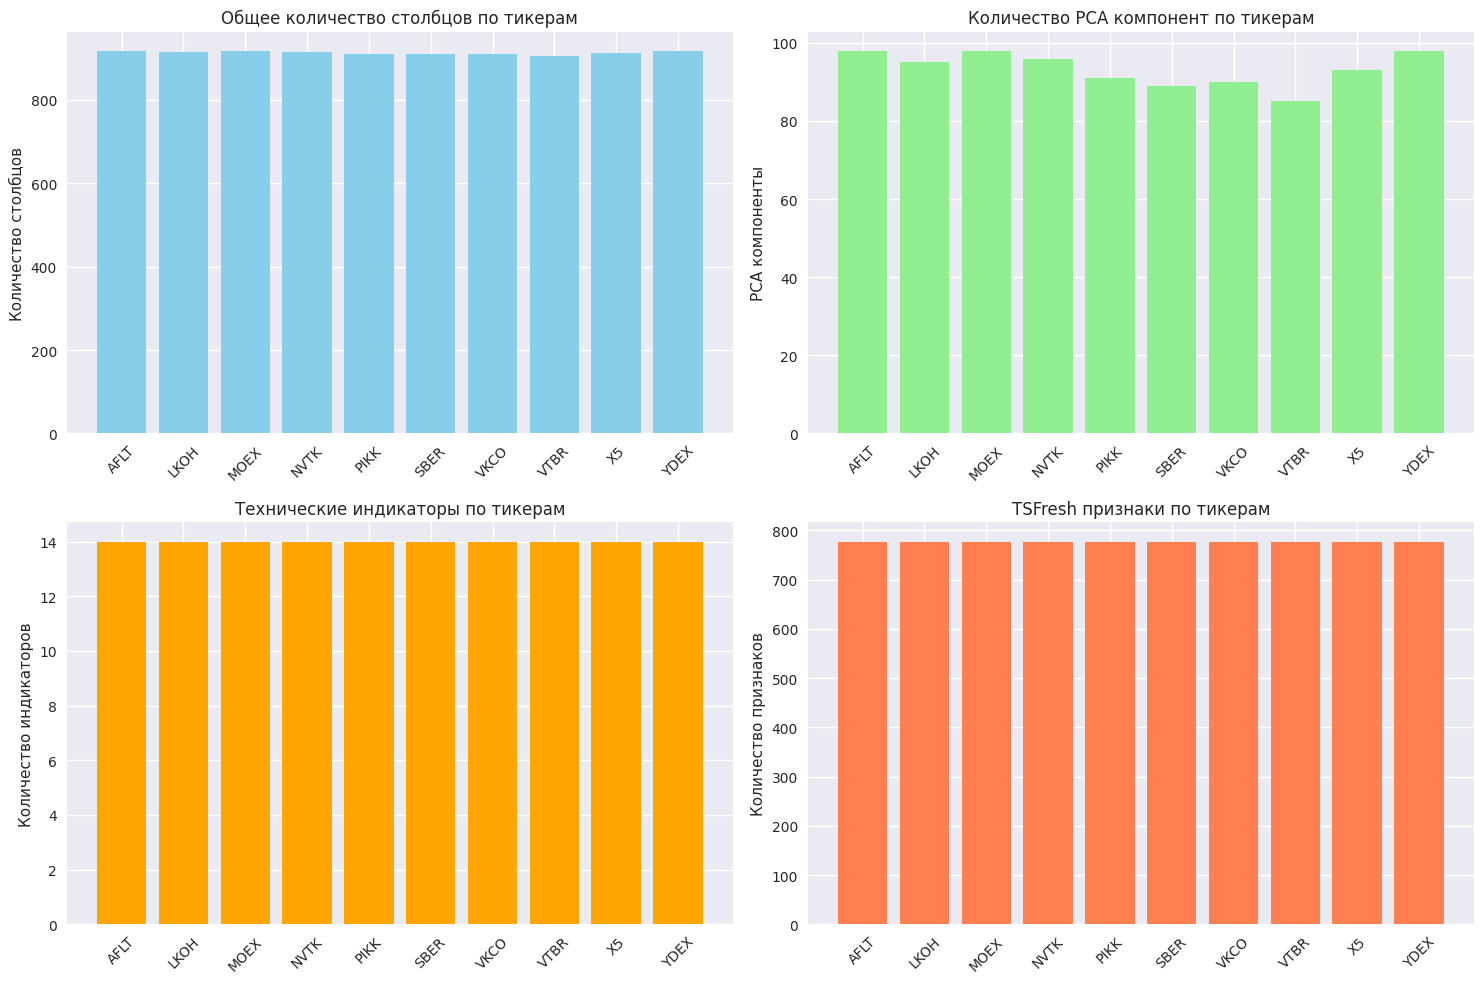

In [40]:
# Визуализация распределения признаков
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# График 1: Количество столбцов по тикерам
axes[0, 0].bar(stats_df['ticker'], stats_df['total_columns'], color='skyblue')
axes[0, 0].set_title('Общее количество столбцов по тикерам')
axes[0, 0].set_ylabel('Количество столбцов')
axes[0, 0].tick_params(axis='x', rotation=45)

# График 2: PCA компоненты
axes[0, 1].bar(stats_df['ticker'], stats_df['pca_components'], color='lightgreen')
axes[0, 1].set_title('Количество PCA компонент по тикерам')
axes[0, 1].set_ylabel('PCA компоненты')
axes[0, 1].tick_params(axis='x', rotation=45)

# График 3: Технические индикаторы
axes[1, 0].bar(stats_df['ticker'], stats_df['technical_indicators'], color='orange')
axes[1, 0].set_title('Технические индикаторы по тикерам')
axes[1, 0].set_ylabel('Количество индикаторов')
axes[1, 0].tick_params(axis='x', rotation=45)

# График 4: TSFresh признаки
axes[1, 1].bar(stats_df['ticker'], stats_df['tsfresh_features'], color='coral')
axes[1, 1].set_title('TSFresh признаки по тикерам')
axes[1, 1].set_ylabel('Количество признаков')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Заключение

В этом ноутбуке была выполнена комплексная инженерия признаков для создания многомерных временных рядов:

### Выполненные этапы:

1. **Технические индикаторы** - добавлено ~25 технических индикаторов:
   - Скользящие средние (SMA, EMA)
   - Осцилляторы (RSI, Stochastic, Williams %R)
   - Трендовые индикаторы (MACD, ADX, CCI)
   - Волатильность (Bollinger Bands, ATR)
   - Объемные индикаторы (OBV, CMF, VWAP)

2. **Графические паттерны** - созданы индикаторы паттернов:
   - Бычьи/медвежьи тренды
   - Перекупленность/перепроданность
   - Пробои Bollinger Bands

3. **TSFresh признаки** - извлечены статистические характеристики временных рядов:
   - Использовано скользящее окно размером 20
   - Применены эффективные параметры для скорости обработки

4. **PCA сжатие** - применено сжатие размерности:
   - Автоматическое определение количества компонент (95% дисперсии)
   - Стандартизация данных перед PCA
   - Сохранение базовых колонок без сжатия

5. **Результаты**:
   - Данные сохранены в папку `data/multivariate_series/`
   - Создана детальная статистика по каждому тикеру
   - Визуализация распределения признаков

### Преимущества созданных данных:
- **Богатое представление** временных рядов с множественными признаками
- **Сжатое пространство** для эффективного машинного обучения
- **Сохранение интерпретируемости** через базовые признаки
- **Готовность для моделирования** различными алгоритмами

Полученные многомерные временные ряды готовы для использования в задачах прогнозирования, классификации аномалий и других задач машинного обучения.
